

## Notebook Summary: Exploring "DiffEdit" for Mask Generation & Image Editing##

This notebook investigates the ["DiffEdit"](https://arxiv.org/abs/2210.11427) technique for automatically generating editing masks. The method involves:
1.  Providing an initial image (as latents).
2.  Using a "source prompt" (describing the original object) and a "target prompt" (describing the desired change).
3.  Generating multiple noisy versions with both prompts and comparing the predicted noise to isolate differences, forming a mask.
4.  This mask is then used to guide image generation with the standard Stable Diffusion model (in a custom img2img-like process) and compared against a dedicated inpainting model.

**Key Conclusions:**
*   **DiffEdit's Effectiveness:** The mask generation works reasonably well *only if* the initial image was itself generated by the Stable Diffusion model (e.g., the dog example where we know the generation prompt and seed). It struggles to create useful masks for arbitrary external photos.
*   **Prompt Sensitivity:** It's difficult to craft source and target prompts that reliably produce a precise and useful mask.
*   **Generalization Issues:** The mask generation technique doesn't generalize well beyond images where the model has a strong prior (i.e., images it can generate well on its own, or for which the original generation parameters are known).
*   **Inpainting Models are Superior:** Dedicated inpainting models (like `StableDiffusionInpaintPipeline`) are significantly more effective and produce much better results for the actual editing task compared to using the DiffEdit-generated mask with the standard Stable Diffusion pipeline.


In [1]:
from base64 import b64encode
import numpy as np
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, PNDMScheduler
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)

if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"
generator = torch.Generator(torch_device).manual_seed(1)


In [2]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [3]:
def tensor_to_latent(tensor):
    with torch.no_grad():
        latent = vae.encode(tensor.to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [4]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

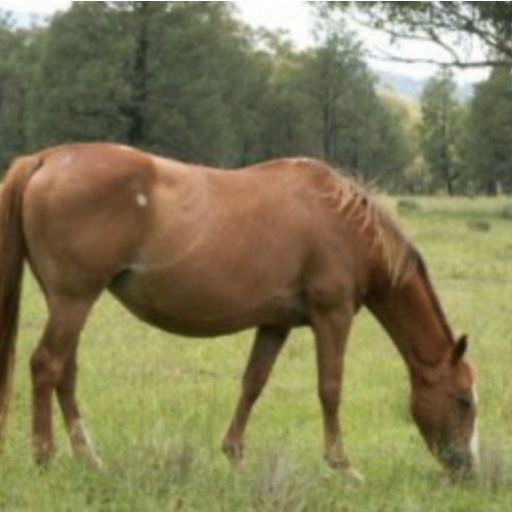

In [5]:
# Load the image with PIL
horse_img = Image.open('horse.png').resize((512,512))
horse_img = horse_img.convert('RGB')
init_image = tfms.ToTensor()(horse_img)
init_latents = pil_to_latent(horse_img)
horse_img

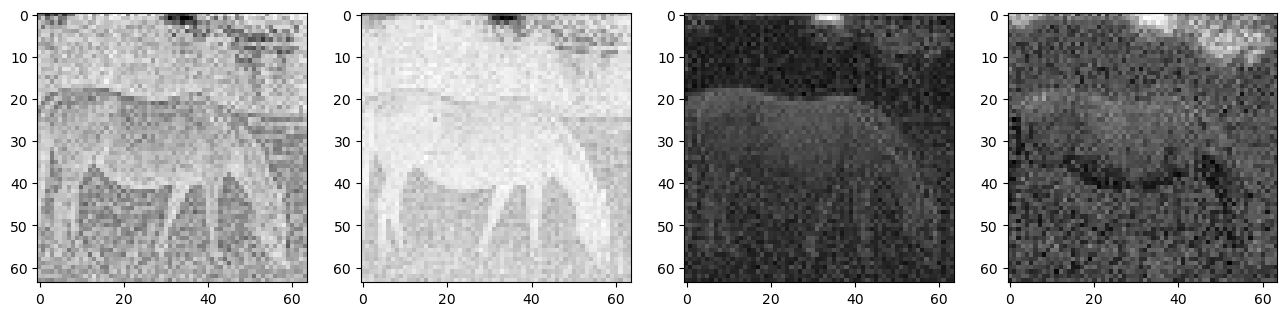

In [6]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(init_latents[0][c].cpu(), cmap='Greys')

In [7]:
def prompt_to_embd(prompt):
	text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
	with torch.no_grad():
		text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
	return text_embeddings

In [8]:
def generate_img(prompt, start_step, init_latents,  num_inference_steps = 50, guidance_scale = 8, seed = 52, progress_bar = True, mask = None):
	height = 512                        # default height of Stable Diffusion
	width = 512                         # default width of Stable Diffusion
	generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
	batch_size = 1

	prompt_emedding = prompt_to_embd(prompt)
	uncond_embeddings = prompt_to_embd("")
	text_embeddings = torch.cat([uncond_embeddings, prompt_emedding])

	# Prep Scheduler (setting the number of inference steps)
	set_timesteps(scheduler, num_inference_steps)

	# Prep latents (noising appropriately for start_step)
	noise = torch.randn_like(init_latents)
	
	latents = scheduler.add_noise(init_latents, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
	latents = latents.to(torch_device).float()


	# Loop
	for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps), disable=not progress_bar):
		if i >= start_step: # << This is the only modification to the loop we do

			# expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
			latent_model_input = torch.cat([latents] * 2)
			sigma = scheduler.sigmas[i]
			latent_model_input = scheduler.scale_model_input(latent_model_input, t)

			# predict the noise residual
			with torch.no_grad():
				noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

			# perform guidance
			noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
			noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

			# compute the previous noisy sample x_t -> x_t-1
			latents = scheduler.step(noise_pred, t, latents).prev_sample
			if mask is not None:
				
				if i < len(scheduler.timesteps)-1:
					noise = torch.rand_like(init_latents)
					noised_init_latents = scheduler.add_noise(init_latents, noise, timesteps=torch.tensor([scheduler.timesteps[i+1]]))
				else: noised_init_latents = init_latents.clone()
				latents = mask * latents + (1-mask) * noised_init_latents

	return latents, noise_pred_text

In [9]:
im1, n1 = generate_img('horse on the green grass', 25, init_latents=init_latents)

100%|██████████| 50/50 [00:03<00:00, 14.98it/s]


In [42]:
def create_mask(prompt_src, prompt_dest, init_latents, start_step=25, niter=10):
	diffs = []
	torch.manual_seed(1)
	seeds = torch.randint(0,2*62, (10,), generator=generator, device=torch_device)
	for i in tqdm(range(niter)):
		im1, n1 = generate_img(prompt_src, start_step, init_latents=init_latents, seed=seeds[i], progress_bar=False)	
		im2, n2 = generate_img(prompt_dest, start_step, init_latents=init_latents,seed=seeds[i], progress_bar=False)
		diffs.append((n1-n2).norm(p=2, dim=1).detach().cpu())
		
	mean_diff = torch.cat(diffs).mean(dim=0)
	normalized_diff = (mean_diff - mean_diff.min())/(mean_diff.max()-mean_diff.min())
	mask = (normalized_diff > 0.5).type(torch.float32)
	return mask

In [11]:
mask = create_mask('horse standing on the grass', 'zebra standing on the grass', init_latents=init_latents)

100%|██████████| 10/10 [01:05<00:00,  6.55s/it]


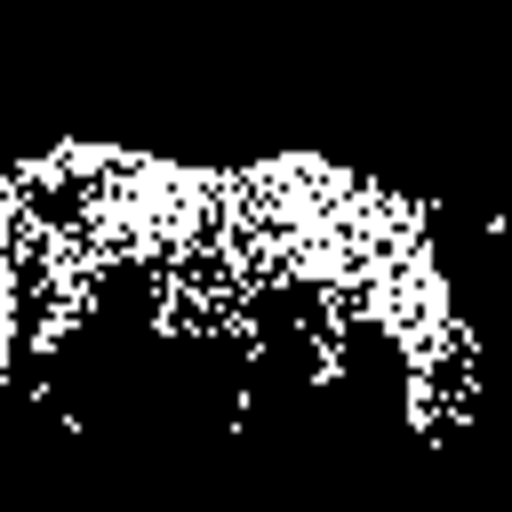

In [12]:
Image.fromarray((mask*255.).cpu().numpy().astype(np.uint8)).resize((512,512))

In [13]:
def smooth_mask(mask):
	smooth_mask = F.max_pool2d(mask[None, None], kernel_size=5, stride=1, padding=2)
	smooth_mask = smooth_mask.squeeze()
	img_mask = Image.fromarray((smooth_mask*255.).cpu().numpy().astype(np.uint8))
	return smooth_mask, img_mask

In [14]:
mask, img_mask = smooth_mask(mask)

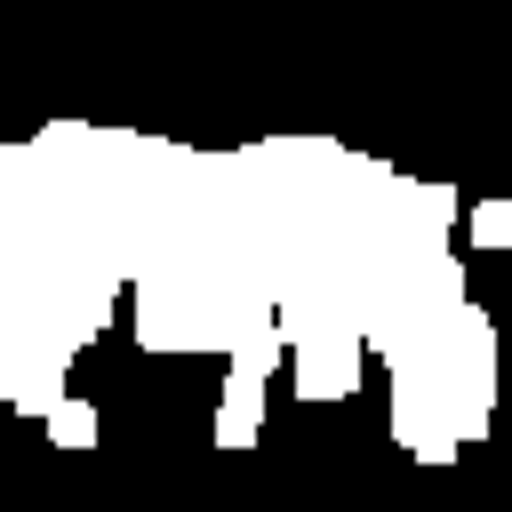

In [15]:
img_mask.resize((512,512))

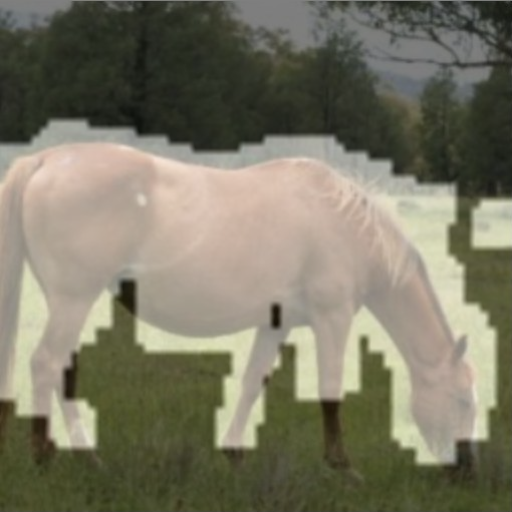

In [16]:
Image.blend(horse_img.convert("RGBA"), img_mask.resize((512,512)).convert("RGBA"), alpha=0.5)

In [17]:
modified, noise = generate_img('huge wolf standing on the grass', 30, init_latents,mask=mask.to(torch_device))

100%|██████████| 50/50 [00:02<00:00, 19.86it/s] 


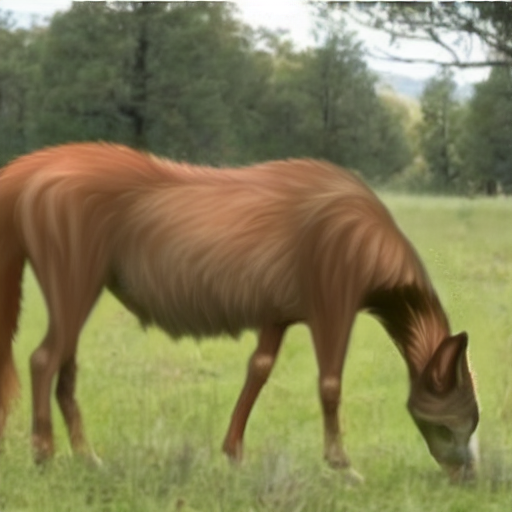

In [18]:
latents_to_pil(modified)[0]

In [19]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(torch_device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
img = pipe('huge wolf standing on the grass', horse_img, F.interpolate(mask[None, None], (512,512)), strength=0.5, generator=generator)

  0%|          | 0/25 [00:00<?, ?it/s]

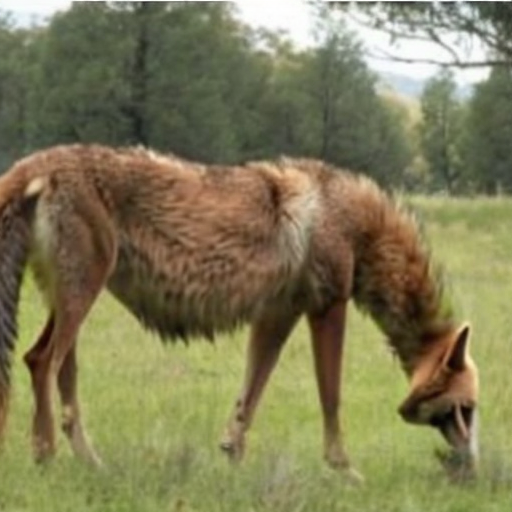

In [21]:
img['images'][0]

In [45]:
im, lat = generate_img('big golden retriver in the center of the grass ', 0, init_latents, seed=0)

100%|██████████| 50/50 [00:06<00:00,  7.65it/s]


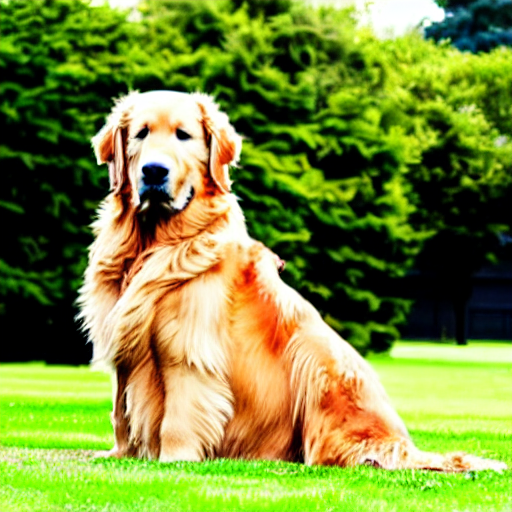

In [46]:


dog_img = latents_to_pil(im)[0]
init_image = tfms.ToTensor()(dog_img)
init_latents = pil_to_latent(dog_img)
dog_img

100%|██████████| 50/50 [00:06<00:00,  7.54it/s]


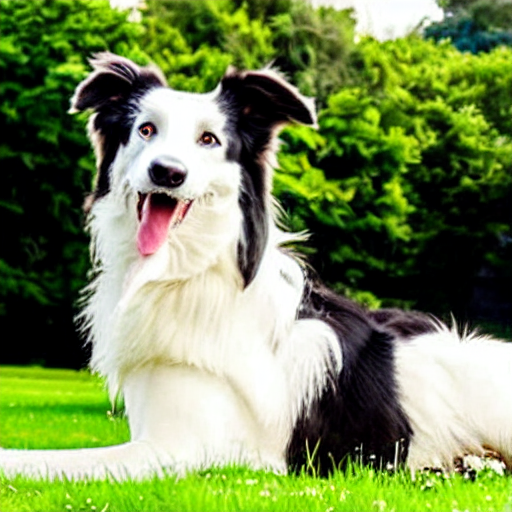

In [35]:
im1, lat = generate_img('big border collie in the center of the grass ', 0, init_latents, seed=0)
latents_to_pil(im1)[0]

In [47]:
dog_mask = create_mask('big golden retriver in the center of the grass ', 'big border collie in the center of the grass ',init_latents, start_step=10 )

100%|██████████| 10/10 [01:44<00:00, 10.48s/it]


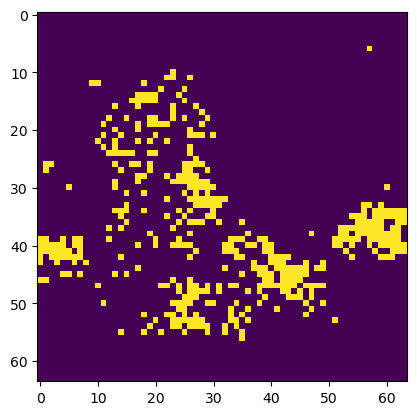

In [48]:
plt.imshow(dog_mask.cpu().numpy())

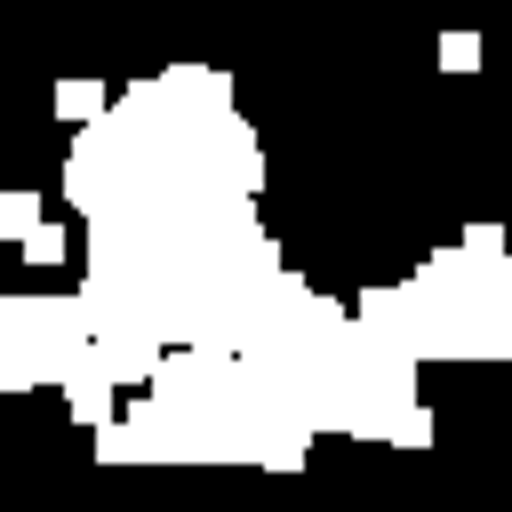

In [49]:
dog_mask, dog_mask_img = smooth_mask(dog_mask)
dog_mask_img.resize((512,512))

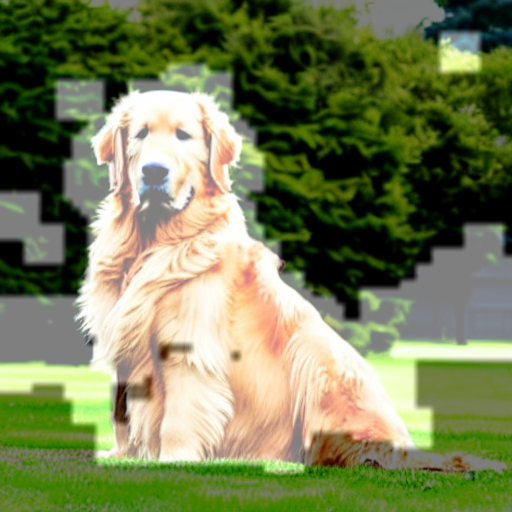

In [50]:
Image.blend(dog_img.convert('RGBA'), dog_mask_img.resize((512,512)).convert('RGBA'), 0.5)

100%|██████████| 50/50 [00:04<00:00, 10.65it/s]


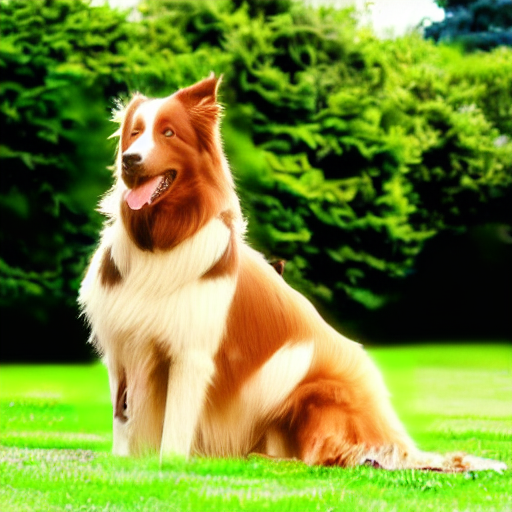

In [58]:

modified, noise = generate_img('big border collie in the center of the grass ', 15, init_latents,mask=dog_mask.to(torch_device), seed=1)
latents_to_pil(modified)[0]

100%|██████████| 50/50 [00:05<00:00,  9.38it/s]


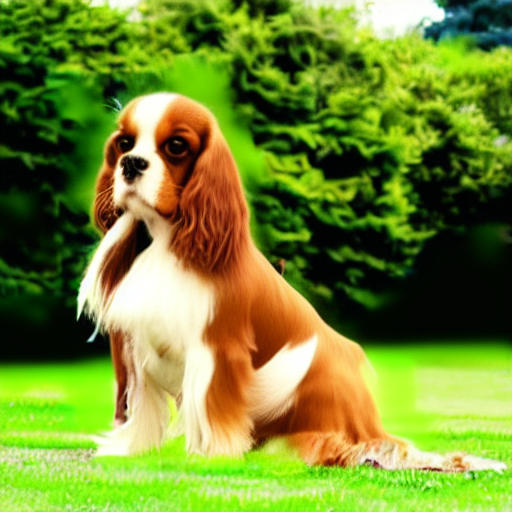

In [61]:
modified, noise = generate_img('big happy Cavalier King Charles Spaniel in the center of the grass ', 10, init_latents,mask=dog_mask.to(torch_device), seed=1)
latents_to_pil(modified)[0]

100%|██████████| 50/50 [00:06<00:00,  7.57it/s]


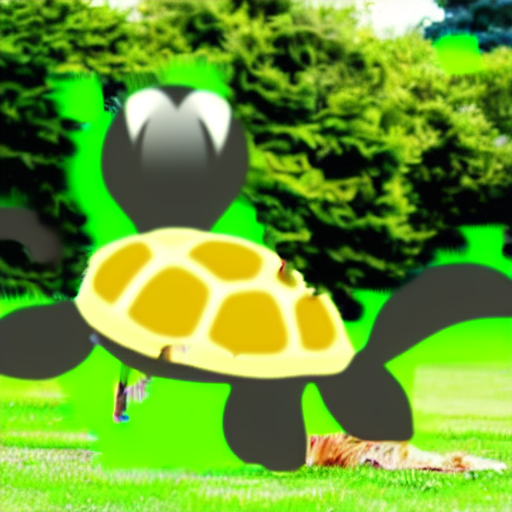

In [117]:
modified, noise = generate_img('laying turtle in the center of the grass ', 0, init_latents,mask=dog_mask.to(torch_device), seed=0)
latents_to_pil(modified)[0]

# Pretrained for inpainting

In [104]:
generator = torch.Generator(torch_device).manual_seed(1)

In [105]:
img = pipe('big Australian Shepherd in the center of the grass ', dog_img, F.interpolate(dog_mask[None, None], (512,512)), strength=1, generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

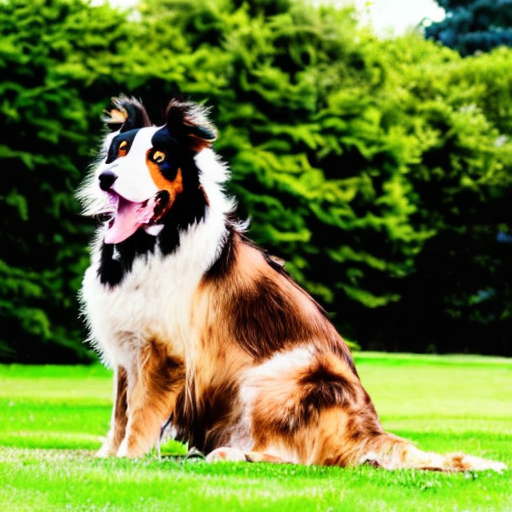

In [106]:
img['images'][0]

In [107]:
generator = torch.Generator(torch_device).manual_seed(1)

In [108]:
img = pipe('big scary yeti  in the center of the grass ', dog_img, F.interpolate(dog_mask[None, None], (512,512)), strength=1, generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

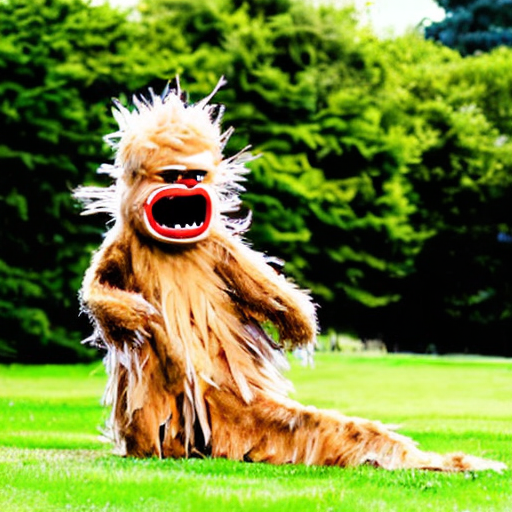

In [109]:
img['images'][0]

In [110]:
generator = torch.Generator(torch_device).manual_seed(1)

In [115]:
img = pipe('laying turtle in the center of the grass ', dog_img, F.interpolate(dog_mask[None, None], (512,512)), strength=1, generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

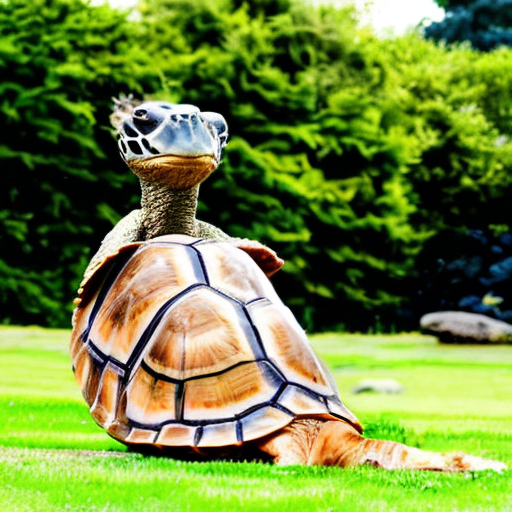

In [116]:
img['images'][0]

In [ ]:
# XDDDDDDDD